# Quy trình Huấn luyện Mô hình YOLO (Object Detection)

## 1. Cài đặt môi trường
```bash
pip install ultralytics
```


## 2. Chuẩn bị dữ liệu (YOLO Format)
### Cấu trúc thư mục 
```yaml
dataset/
├── train/
│   ├── images/
│   └── labels/
├── val/
│   ├── images/
│   └── labels/
```

Các File trong folder labels có định dạng .txt:
Mỗi dòng trong file .txt tương ứng với 1 object:
```yaml
<class_id> <x_center> <y_center> <width> <height>
```

Một số trang support đánh nhãn dữ liệu: Roboflow

Một số trang có nguồn dữ liệu: Kaggle, Roboflow

## 3. Tạo file cấu hình data.yaml
```yaml
train: /path/to/images/train  # Đường dẫn tới tập train
val: /path/to/images/val      # Đường dẫn tới tập val

nc: 2
names: ['smoke', 'fire'] 
```

## 4. Huấn luyện mô hình
### Với YOLOv8
#### Mã CLI
```bash
yolo task=detect mode=train model=yolov8n.pt data=data.yaml epochs=100 imgsz=640 batch=16  name=yolo_custom
```
#### Mã Python
```python
model = YOLO('yolov8n.pt')  # Có thể thay yolov8n.pt bằng yolov8s.pt, yolov8m.pt, v.v.

model.train(
    data='data/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16
)
```

Sau khi train xong, một thư mục mới sẽ được tạo
```yaml
runs/dectect/train/  
├── weights/  
│   ├── best.pt --> Trọng số tốt nhất  
│   └── last.pt --> Trọng số ở lần train cuối cùng  
├── results.csv --> Các chỉ số qua các each  
├── results.png --> Đồ thị thể hiện các chỉ số  
├── ....  
```


## 5. Đánh giá mô hình

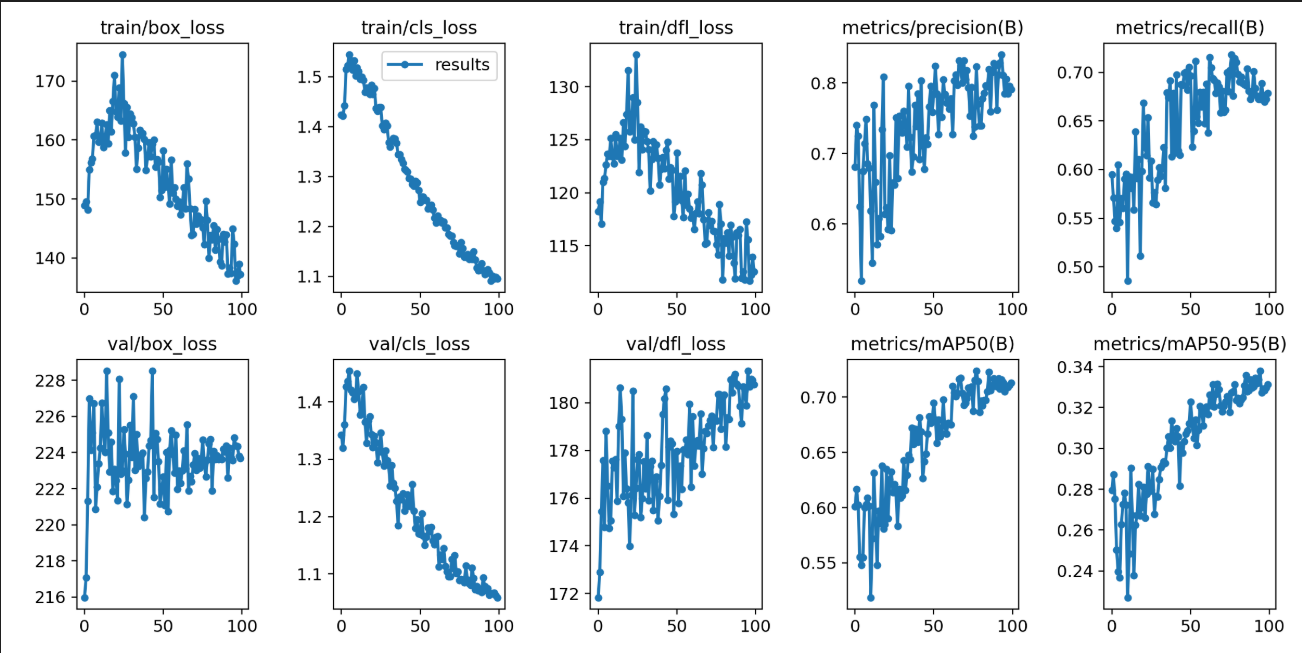

#### box_loss - Bounding Box Loss   
- Đo mức độ chính xác giữa tọa độ hộp giới hạn mô hình dự đoán so với hộp giới hạn được đánh nhãn (Dùng CIoU, DIoU, GIoU)
- Giá trị này càng thấp thì càng tốt

#### cls_loss - Classification Loss   
- Đo mức độ chính xác giữa nhãn của mô hình dự đoán so với nhãn được đánh nhãn (Dùng BCE - binary cross-entropy)
- Giá trị này càng thấp thì càng tốt

#### dfl_loss - Distribution Focal Loss  
- Dùng trong các phiên bản YOLO mới như YOLOv8 để cải thiện chất lượng định vị hộp thông qua kỹ thuật phân phối xác suất.
- DFL không chỉ dự đoán tọa độ mà còn học phân phối xác suất cho mỗi tọa độ, giúp định vị mượt và chính xác hơn.
- Giá trị này càng thấp càng tốt

#### Precision - Độ chính xác  
- Trả lời cho câu hỏi: Trong số tất cả các dự đoán có vật thể, có bao nhiêu là đúng?
- Chỉ số này càng cao càng tốt

$$
Precision = \frac{TP}{TP + FP}
$$
Với: 
  - $TP$ (True Positive): Dự đoán đúng vật thể  
  - $FP$ (False Possitive): Dự đoán nhầm, tức mô hình dự đoán có vật thể trong ảnh, nhưng thực tế thì không có  


#### Recall - Độ bao phủ
- Trả lời cho câu hỏi: Trong số tất cả các vật thể thực sự có trong ảnh, mô hình dự đoán đúng được bao nhiêu?
- Chỉ số này càng cao càng tốt
$$
Recall = \frac{TP}{TP + FN}
$$
Với:
  - $TP$ (True Positive): Dự đoán đúng vật thể  
  - $FN$ (False Negative): Mô hình dự đoán không có vật thể có trong ảnh, nhưng thực tế là có

#### mAP@0.5 - Mean Average Precision (IoU 0.5)
- IoU (Intersection over Union): Tỉ lệ chồng lấp giữa box dự đoán và box thực tế.
- mAP@0.5 nghĩa là chỉ cần IoU ≥ 0.5 (50% chồng lấp) là chấp nhận là đúng.
- mAP (mean average precision): trung bình của average precision qua các lớp và các ngưỡng confidence.
- Chỉ số này càng cao tức mô hình dự đoán vị trí của các box càng đúng

#### mAP@0.5:0.95 – Trung bình AP từ IoU 0.5 đến 0.95
- Tính mAP ở nhiều mức IoU: 0.5, 0.55, 0.6, ..., 0.95 (tăng mỗi 0.05).
- Sau đó lấy trung bình.

## 6. Dự đoán (Inference)
Mã Python
```python
results = model.predict(source, show=False, conf=0.5)
```
Trong đó: 
- results: là một số tượng, gồm các thông tin: danh sách các bounding box được phát hiện, nhãn tương ứng, độ tin cậy...
- source: ảnh đầu vào  
- conf: ngưỡng tối thiểu để mô hình giữa lại dự đoán
- show: tùy chọn hiển thị ảnh đầu ra hoặc không


In [16]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [17]:
# Load
model = YOLO("best.pt")

In [18]:
def detect(model, images, threshold=0.5):
    plt.figure(figsize=[10 * len(images), 50])
    for i in range(len(images)):
        results = model.predict(images[i], conf=threshold)
        frame   = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)
        plt.subplot(len(images), 1, i + 1); plt.imshow(frame); plt.title(f"Test{i + 1}")


0: 256x416 1 fire-indoor, 1 light, 20.9ms
Speed: 3.0ms preprocess, 20.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 fire-indoors, 1 light, 28.0ms
Speed: 3.4ms preprocess, 28.0ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 fire-indoor, 27.0ms
Speed: 3.4ms preprocess, 27.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 416)

0: 320x416 1 fire-indoor, 3 lights, 24.0ms
Speed: 4.9ms preprocess, 24.0ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 fire-indoor, 22.6ms
Speed: 2.6ms preprocess, 22.6ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

0: 416x320 1 fire-indoor, 1 light, 15.4ms
Speed: 2.8ms preprocess, 15.4ms inference, 5.3ms postprocess per image at shape (1, 3, 416, 416)

0: 288x416 1 fire-indoor, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 6.1ms postprocess per image at shape (1, 3, 416, 416)

0: 416x288 1 light, 16.2ms
Speed: 2.0ms prep

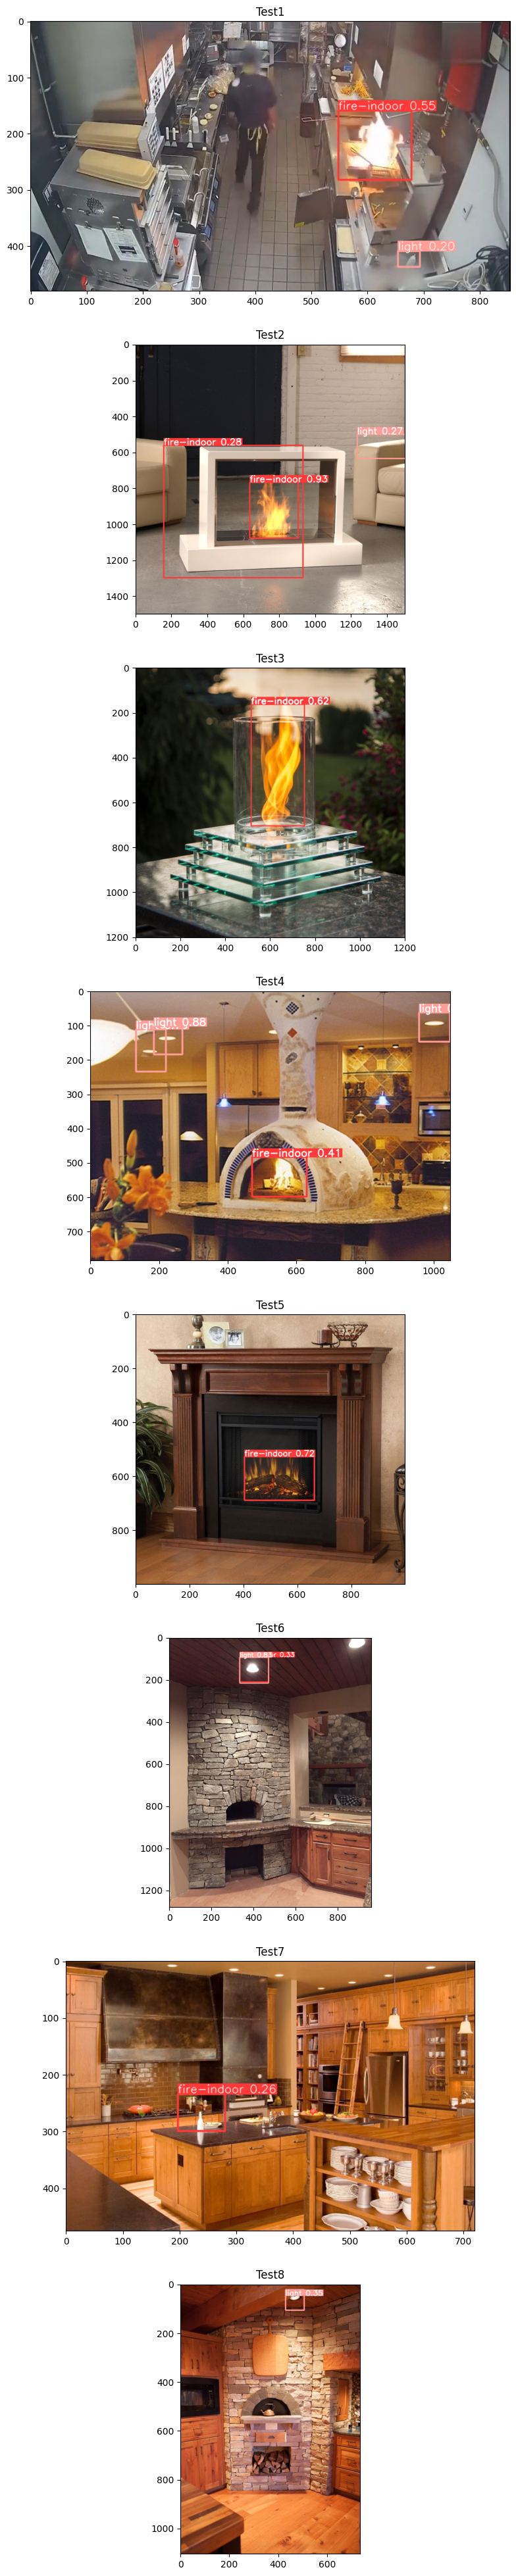

In [19]:
images = []
for i in range(1, 9):
    path = f"Test/test{i}.jpg"
    src = cv2.imread(path, cv2.IMREAD_COLOR)
    images.append(src)

detect(model, images, 0.2)